In [1]:
import pandas as pd
import numpy as np
from keras import models
from keras import layers
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
from keras.models import load_model
from PIL import Image, ImageOps, ImageFilter
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
import tensorflow as tf
%matplotlib inline
np.random.seed(123)
import os
from keras.applications import inception_v3
from keras.applications import InceptionResNetV2
from keras.applications import VGG16
from keras.applications import Xception
from keras.applications import ResNet152
from keras.layers import Dense,GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, f1_score
from keras.models import Model

Using TensorFlow backend.


In [2]:
# Getting mirror images for normal to deal with class imbalance
"""
for filename in os.listdir('chest_xray/train/NORMAL'):
    if filename.endswith('.jpeg'):
        im = Image.open(os.path.join('chest_xray/train/NORMAL/', filename))
        im_mirror = ImageOps.mirror(im)
        im_mirror.save('chest_xray/train/NORMAL/mirror_'+filename)
    else:
        continue
"""

"\nfor filename in os.listdir('chest_xray/train/NORMAL'):\n    if filename.endswith('.jpeg'):\n        im = Image.open(os.path.join('chest_xray/train/NORMAL/', filename))\n        im_mirror = ImageOps.mirror(im)\n        im_mirror.save('chest_xray/train/NORMAL/mirror_'+filename)\n    else:\n        continue\n"

In [3]:
"""
i = 0
for filename in os.listdir('chest_xray/train/NORMAL'):
    if filename.endswith('.jpeg'):
        im = Image.open(os.path.join('chest_xray/train/NORMAL/', filename))
        im=im.convert("RGB")
        if i % 2 == 0:
            new = im.filter(ImageFilter.GaussianBlur)
        else:
            new = im.filter(ImageFilter.UnsharpMask)
        new.save('chest_xray/train/NORMAL/augment_'+filename)
        i += 1
    else:
        continue
    if i  == 1185:
        break
"""

'\ni = 0\nfor filename in os.listdir(\'chest_xray/train/NORMAL\'):\n    if filename.endswith(\'.jpeg\'):\n        im = Image.open(os.path.join(\'chest_xray/train/NORMAL/\', filename))\n        im=im.convert("RGB")\n        if i % 2 == 0:\n            new = im.filter(ImageFilter.GaussianBlur)\n        else:\n            new = im.filter(ImageFilter.UnsharpMask)\n        new.save(\'chest_xray/train/NORMAL/augment_\'+filename)\n        i += 1\n    else:\n        continue\n    if i  == 1185:\n        break\n'

In [7]:
train = ImageDataGenerator(rescale=1./255).flow_from_directory(
        directory = '/floyd/input/chest_xray/train',
        class_mode = 'binary',
        target_size = (256, 256),
        batch_size = 7772) 

Found 7772 images belonging to 2 classes.


In [8]:
test = ImageDataGenerator(rescale=1./255).flow_from_directory(
        directory = '/floyd/input/chest_xray/test',
        class_mode = 'binary',
        target_size = (256, 256),
        batch_size = 624) 

Found 624 images belonging to 2 classes.


In [9]:
# Spliting images and labels
test_images, test_labels = next(test)
train_images, train_labels = next(train)


In [10]:
test_labels = np.reshape(test_labels, (len(test_labels),1)).astype(int)
train_labels = np.reshape(train_labels, (len(train_labels),1)).astype(int)

In [11]:
x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.20, random_state=123)

In [12]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  3)))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [13]:
cnn1 = cnn.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=50,
                    validation_data=(x_val, y_val),
                      workers = -1)

Train on 6217 samples, validate on 1555 samples
Epoch 1/10
6217/6217 [==============================] - 39s 6ms/step - loss: 0.6187 - acc: 0.6936 - val_loss: 0.4531 - val_acc: 0.7923
Epoch 2/10
6217/6217 [==============================] - 33s 5ms/step - loss: 0.4101 - acc: 0.8198 - val_loss: 0.2265 - val_acc: 0.9248
Epoch 3/10
6217/6217 [==============================] - 33s 5ms/step - loss: 0.2270 - acc: 0.9099 - val_loss: 0.1396 - val_acc: 0.9505
Epoch 4/10
6217/6217 [==============================] - 34s 5ms/step - loss: 0.1885 - acc: 0.9287 - val_loss: 0.1248 - val_acc: 0.9518
Epoch 5/10
6217/6217 [==============================] - 33s 5ms/step - loss: 0.1527 - acc: 0.9406 - val_loss: 0.1352 - val_acc: 0.9505
Epoch 6/10
6217/6217 [==============================] - 34s 5ms/step - loss: 0.1357 - acc: 0.9460 - val_loss: 0.1433 - val_acc: 0.9441
Epoch 7/10
6217/6217 [==============================] - 33s 5ms/step - loss: 0.1293 - acc: 0.9506 - val_loss: 0.1209 - val_acc: 0.9543
Epoch 8

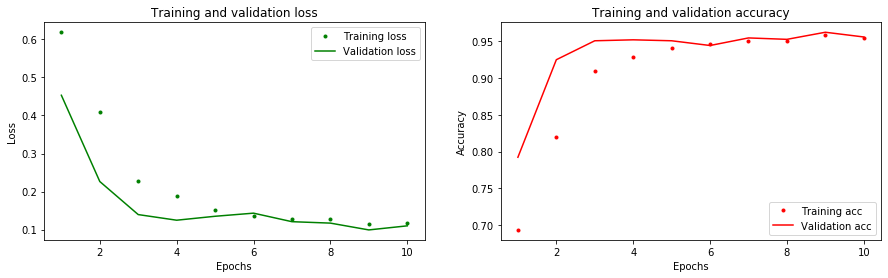

In [14]:
hist_cnn = cnn1.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['acc'] 
val_acc_values = hist_cnn['val_acc']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
results_train = cnn.evaluate(x_train, y_train)
results_test = cnn.evaluate(test_images, test_labels)
print(results_train, results_test)

624/624 [==============================] - 1s 2ms/step
[0.11485789918537134, 0.956088125705719] [0.8565133596077944, 0.7355769276618958]


In [16]:
def predictoneimage_cnn(model, path):
    img = load_img(path, target_size=(256, 256))
    plt.imshow(img)
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)
    predict = model.predict(img)
    return predict


array([[0.7589363]], dtype=float32)

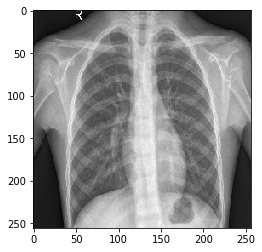

In [17]:
predictoneimage_cnn(cnn, '/floyd/input/chest_xray/test/NORMAL/IM-0001-0001.jpeg')

array([[0.9984018]], dtype=float32)

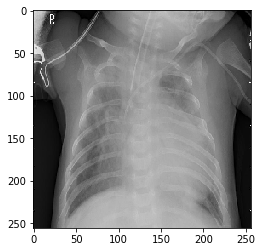

In [18]:
predictoneimage_cnn(cnn, '/floyd/input/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg')

## Inception V3

In [19]:
imagenet=inception_v3.InceptionV3(weights='imagenet',include_top=False)
imagenet_new=imagenet.output
new_model = models.Sequential()
new_model.add(imagenet)
new_model.add(GlobalAveragePooling2D())
new_model.add(Dense(1024,activation='relu'))
new_model.add(Dense(1024,activation='relu')) #dense layer 2
new_model.add(Dense(512,activation='relu')) #dense layer 3
new_model.add(Dense(1,activation='sigmoid')) #final layer with softmax activation

In [20]:
new_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.Recall()])

# step_size_train=train_generator.n//train_generator.batch_size
nm = new_model.fit(x_train,
             y_train,
             epochs = 10,
             batch_size=50,
             validation_data = (x_val, y_val),
                  workers = -1)

Train on 6217 samples, validate on 1555 samples
Epoch 1/10
6217/6217 [==============================] - 278s 45ms/step - loss: 0.1520 - accuracy: 0.9469 - recall: 0.8823 - val_loss: 0.9318 - val_accuracy: 0.8791 - val_recall: 0.9242
Epoch 2/10
6217/6217 [==============================] - 223s 36ms/step - loss: 0.0590 - accuracy: 0.9812 - recall: 0.9260 - val_loss: 0.0264 - val_accuracy: 0.9936 - val_recall: 0.9425
Epoch 3/10
6217/6217 [==============================] - 223s 36ms/step - loss: 0.0317 - accuracy: 0.9887 - recall: 0.9517 - val_loss: 0.1026 - val_accuracy: 0.9762 - val_recall: 0.9572
Epoch 4/10
6217/6217 [==============================] - 223s 36ms/step - loss: 0.0349 - accuracy: 0.9873 - recall: 0.9607 - val_loss: 0.0922 - val_accuracy: 0.9833 - val_recall: 0.9634
Epoch 5/10
6217/6217 [==============================] - 223s 36ms/step - loss: 0.0288 - accuracy: 0.9899 - recall: 0.9660 - val_loss: 0.0691 - val_accuracy: 0.9814 - val_recall: 0.9687
Epoch 6/10
6217/6217 [=====

In [ ]:
inceptionv3_train = new_model.evaluate(x_train, y_train)
inceptionv3_test = new_model.evaluate(test_images, test_labels)
print(inceptionv3_train, inceptionv3_test)

## VGG 16

In [ ]:
vgg = VGG16(weights='imagenet',include_top=False, input_shape = (128,128,3))
vgg_new = vgg.output
vgg_model = models.Sequential()
vgg_model.add(vgg)
vgg_model.add(GlobalAveragePooling2D())
vgg_model.add(Dense(1024,activation='relu'))
vgg_model.add(Dense(1024,activation='relu')) #dense layer 2
vgg_model.add(Dense(512,activation='relu')) #dense layer 3
vgg_model.add(Dense(1,activation='sigmoid')) #final layer with softmax activation

In [ ]:
vgg_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.Recall()])

# step_size_train=train_generator.n//train_generator.batch_size
nm = vgg_model.fit(x_train,
             y_train,
             epochs = 10,
             batch_size=50,
             validation_data = (x_val, y_val),
                  workers = -1)

In [ ]:
vgg16_train = vgg_model.evaluate(x_train, y_train)
vgg16_test = vgg_model.evaluate(test_images, test_labels)
print(vgg16_train, vgg16_test)

## InceptionResNetV2

In [ ]:
resnetv2 = InceptionResNetV2(weights='imagenet',include_top=False, input_shape = (128,128,3))
resnetv2_new = resnetv2.output
rn_model = models.Sequential()
rn_model.add(resnetv2)
rn_model.add(GlobalAveragePooling2D())
rn_model.add(Dense(1024,activation='relu'))
rn_model.add(Dense(1024,activation='relu')) #dense layer 2
rn_model.add(Dense(512,activation='relu')) #dense layer 3
rn_model.add(Dense(1,activation='sigmoid')) #final layer with softmax activation

In [ ]:
rn_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.Recall()])

# step_size_train=train_generator.n//train_generator.batch_size
rn = rn_model.fit(x_train,
             y_train,
             epochs = 10,
             batch_size=50,
             validation_data = (x_val, y_val),
                  workers = -1)

In [ ]:
resnet_train = rn_model.evaluate(x_train, y_train)
resnet_test = rn_model.evaluate(test_images, test_labels)
print(resnet_train, resnet_test)

## Xception

In [ ]:
Xception = Xception(weights = 'imagenet', include_top=False, input_shape = (128,128,3))
Xception_new = Xception.output
xc_model = models.Sequential()
xc_model.add(Xception)
xc_model.add(GlobalAveragePooling2D())
xc_model.add(Dense(1024,activation='relu'))
xc_model.add(Dense(1024,activation='relu')) #dense layer 2
xc_model.add(Dense(512,activation='relu')) #dense layer 3
xc_model.add(Dense(1,activation='sigmoid')) #final layer with softmax activation

In [ ]:
xc_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.Recall()])

# step_size_train=train_generator.n//train_generator.batch_size
xc = xc_model.fit(x_train,
             y_train,
             epochs = 10,
             batch_size=50,
             validation_data = (x_val, y_val),
                  workers = -1)

In [ ]:
Xception_train = xc_model.evaluate(x_train, y_train)
Xception_test = xc_model.evaluate(test_images, test_labels)
print(Xception_train, Xception_test)

## ResNet152

In [ ]:
resnet152 = ResNet152(weights = 'imagenet', include_top=False, input_shape = (128,128,3))
resnet152_new = resnet152.output
rn152_model = models.Sequential()
rn152_model.add(resnet152)
rn152_model.add(GlobalAveragePooling2D())
rn152_model.add(Dense(1024,activation='relu'))
rn152_model.add(Dense(1024,activation='relu')) #dense layer 2
rn152_model.add(Dense(512,activation='relu')) #dense layer 3
rn152_model.add(Dense(1,activation='sigmoid')) #final layer with softmax activation

In [ ]:
rn152_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.Recall()])

# step_size_train=train_generator.n//train_generator.batch_size
rn152 = rn152_model.fit(x_train,
             y_train,
             epochs = 10,
             batch_size=50,
             validation_data = (x_val, y_val),
                  workers = -1)

In [ ]:
resnet152_train = rn152_model.evaluate(x_train, y_train)
resnet152_test = rn152_model.evaluate(test_images, test_labels)
print(resnet152_train, resnet152_test)